![](https://seeklogo.com/images/T/tripadvisor-logo-6939149F8F-seeklogo.com.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [335]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./data/kaggle_task.csv
./data/main_task.csv
./data/sample_submission.csv


In [336]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [337]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [338]:
DATA_DIR = './data'
df_train = pd.read_csv(DATA_DIR + '/main_task.csv')
df_test = pd.read_csv(DATA_DIR + '/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR + '/sample_submission.csv')

In [339]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [340]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [341]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [342]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [343]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [344]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [345]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [346]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* `City`: Город 
* `Cuisine Style`: Кухня
* `Ranking`: Ранг ресторана относительно других ресторанов в этом городе
* `Price Range`: Цены в ресторане в 3 категориях
* `Number of Reviews`: Количество отзывов
* `Reviews`: 2 последних отзыва и даты этих отзывов
* `URL_TA`: страница ресторана на 'www.tripadvisor.com' 
* `ID_TA`: ID ресторана в TripAdvisor
* `Rating`: Рейтинг ресторана

In [347]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
47717,id_5929,Milan,"['Italian', 'Bar', 'Cafe', 'European', 'Vegeta...",5932.0,$$ - $$$,315.0,"[['Grumpy Bartender & Happy Waiter', 'Pandino'...",/Restaurant_Review-g187849-d3802444-Reviews-Pa...,d3802444,1,3.0
31460,id_642,London,"['Italian', 'Pizza', 'Mediterranean', 'Europea...",643.0,$$ - $$$,892.0,"[['Not bad at all', 'Great Lobster Pasta'], ['...",/Restaurant_Review-g186338-d1501595-Reviews-Si...,d1501595,1,4.0
38670,id_229,Ljubljana,NaN,230.0,NaN,5.0,"[['Tasty, decent portions and not expensive', ...",/Restaurant_Review-g274873-d11890718-Reviews-R...,d11890718,1,4.0
18540,id_4688,Madrid,"['Pub', 'Gastropub']",4691.0,$$ - $$$,11.0,"[['Great experience', 'Good beers and tapas at...",/Restaurant_Review-g187514-d12877940-Reviews-W...,d12877940,1,4.0
12300,id_1817,Milan,"['Wine Bar', 'Italian', 'Diner', 'Vegetarian F...",1819.0,$$ - $$$,27.0,"[['Amazing'], ['05/31/2016']]",/Restaurant_Review-g187849-d10145896-Reviews-F...,d10145896,1,4.5


In [348]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [349]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [350]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [351]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [352]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [353]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [354]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [355]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
15688,id_3505,"['Chinese', 'Asian', 'Vegetarian Friendly']",3506.0,$$$$,460.0,"[['Tasty', 'Quality lite steamed Chinese'], ['...",/Restaurant_Review-g187147-d715050-Reviews-Die...,d715050,1,3.5,...,0,0,1,0,0,0,0,0,0,0
27117,id_3501,"['Japanese', 'Sushi']",3502.0,$$ - $$$,70.0,"[[], []]",/Restaurant_Review-g187791-d11672823-Reviews-R...,d11672823,1,4.0,...,0,0,0,0,1,0,0,0,0,0
39575,id_13036,NaN,13046.0,NaN,6.0,"[['A big Disappointment', 'Numerous visits'], ...",/Restaurant_Review-g186338-d8510952-Reviews-HM...,d8510952,1,4.0,...,0,0,0,0,0,0,0,0,0,0
48627,id_4290,['Spanish'],4292.0,NaN,6.0,"[[], []]",/Restaurant_Review-g187514-d4600969-Reviews-Ta...,d4600969,1,4.5,...,0,0,0,0,0,0,0,0,0,0
927,id_927,"['French', 'European', 'Vegetarian Friendly']",1071.0,$$ - $$$,204.0,"[['I strongly recommend this place', 'Nice sur...",/Restaurant_Review-g187147-d942681-Reviews-Tie...,d942681,0,0.0,...,0,0,1,0,0,0,0,0,0,0


#### Возьмем следующий признак "Price Range".

In [356]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [357]:
data['Price Range'].replace(to_replace={ '$': 1, '$$ - $$$': 2, '$$$$': 3}, inplace=True)
data['Price Range'].value_counts()

2.0    23041
1.0     7816
3.0     1782
Name: Price Range, dtype: int64

Сохраним данные о записях, где не был указан уровень цен.

In [358]:
data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')
data['Price_Range_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    1
49998    0
49999    0
Name: Price_Range_isNAN, Length: 50000, dtype: uint8

Заполним пропуски, пока что воспользуемся просто медианой.

In [359]:
data['Price Range'].fillna(data['Price Range'].median(), inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            50000 non-null  object 
 1   Cuisine Style            38410 non-null  object 
 2   Ranking                  50000 non-null  float64
 3   Price Range              50000 non-null  float64
 4   Number of Reviews        50000 non-null  float64
 5   Reviews                  49998 non-null  object 
 6   URL_TA                   50000 non-null  object 
 7   ID_TA                    50000 non-null  object 
 8   sample                   50000 non-null  int64  
 9   Rating                   50000 non-null  float64
 10  Number_of_Reviews_isNAN  50000 non-null  uint8  
 11  City_Amsterdam           50000 non-null  uint8  
 12  City_Athens              50000 non-null  uint8  
 13  City_Barcelona           50000 non-null  uint8  
 14  City_Berlin           

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

#### Возьмем следующий признак "Cuisine Style".

Для начала добавим к записям признак с колличеством представленых типов кухонь. Если в данных отсутствует информация о типах кухонь, то считаем, что в этом ресторане предлагается только один тип кухни. Так же пометим записи, где не укзан тип кухни.

In [360]:
def string_to_list(s):
    return s[1:-1].replace("'", "").split(', ')

def count_styles(s):
    return len(string_to_list(s)) if s is not np.nan else 1

data['Cuisine Style Count'] = data['Cuisine Style'].apply(count_styles)

data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')

data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Price_Range_isNAN,Cuisine Style Count,Cuisine_Style_isNAN
0,id_0,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,0,0,0,0,0,0,2,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,5,0
2,id_2,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,5,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,6,0


Теперь отдельными признаками добавим типы кухни, которые представлены хотя бы в 1% ресторанов.

Для начала соберем список всех кухонь представленых в датасете.

In [361]:
cuisines = set()
for cuisine in data['Cuisine Style'].dropna().values:
    cuisines.update(string_to_list(cuisine))
print(cuisines)

{'Tibetan', 'Ukrainian', 'Latvian', 'Vegan Options', 'Taiwanese', 'Asian', 'Indian', 'Central American', 'Cafe', 'Korean', 'Norwegian', 'Contemporary', 'Central European', 'Mediterranean', 'Caucasian', 'Gastropub', 'American', 'Eastern European', 'Moroccan', 'Bangladeshi', 'Russian', 'Middle Eastern', 'Vietnamese', 'Mongolian', 'Singaporean', 'Minority Chinese', 'Romanian', 'Sri Lankan', 'Grill', 'Fujian', 'Vegetarian Friendly', 'Peruvian', 'Halal', 'Turkish', 'International', 'Bar', 'Seafood', 'Pizza', 'Scottish', 'Filipino', 'Kosher', 'Venezuelan', 'Austrian', 'Cuban', 'Welsh', 'Japanese', 'Latin', 'Chinese', 'Steakhouse', 'Cambodian', 'Soups', 'Spanish', 'Central Asian', 'Hungarian', 'French', 'Israeli', 'Malaysian', 'Burmese', 'Polynesian', 'Polish', 'Sushi', 'Ecuadorean', 'Thai', 'Salvadoran', 'Brazilian', 'Portuguese', 'Australian', 'South American', 'Swedish', 'Yunnan', 'Jamaican', 'Arabic', 'Fusion', 'African', 'Belgian', 'Healthy', 'Nepali', 'Barbecue', 'Tunisian', 'British', 

Теперь соберем данные о том, в скольки ресторанах представлена каждая кухня.

In [362]:
cuisines_rating = {}
for cuisine in cuisines:
    cuisines_rating[cuisine] = 0

def update_cuisines_rating(cuisine_styles):
    for style in cuisine_styles:
        cuisines_rating[style] = cuisines_rating[style] + 1

for cuisine in data['Cuisine Style'].dropna().values:
    update_cuisines_rating(string_to_list(cuisine))

print(cuisines_rating)

{'Tibetan': 29, 'Ukrainian': 20, 'Latvian': 1, 'Vegan Options': 5684, 'Taiwanese': 30, 'Asian': 3786, 'Indian': 1328, 'Central American': 168, 'Cafe': 2883, 'Korean': 206, 'Norwegian': 96, 'Contemporary': 652, 'Central European': 1727, 'Mediterranean': 7820, 'Caucasian': 4, 'Gastropub': 608, 'American': 1642, 'Eastern European': 629, 'Moroccan': 173, 'Bangladeshi': 100, 'Russian': 66, 'Middle Eastern': 980, 'Vietnamese': 622, 'Mongolian': 20, 'Singaporean': 21, 'Minority Chinese': 12, 'Romanian': 13, 'Sri Lankan': 30, 'Grill': 617, 'Fujian': 2, 'Vegetarian Friendly': 14021, 'Peruvian': 130, 'Halal': 773, 'Turkish': 574, 'International': 1966, 'Bar': 4094, 'Seafood': 1878, 'Pizza': 3502, 'Scottish': 199, 'Filipino': 17, 'Kosher': 56, 'Venezuelan': 51, 'Austrian': 462, 'Cuban': 32, 'Welsh': 3, 'Japanese': 1860, 'Latin': 373, 'Chinese': 1446, 'Steakhouse': 729, 'Cambodian': 22, 'Soups': 630, 'Spanish': 3456, 'Central Asian': 12, 'Hungarian': 444, 'French': 3970, 'Israeli': 90, 'Malaysian'

Теперь создадим отдельные признаки для кухонь представленых хотя бы в 1% для остальных добавим признак Cuisine_Other

In [363]:
top_cuisines = []
low_cuisines = []
for cuisine in cuisines_rating:
    if cuisines_rating[cuisine] > len(data) * .01:
        top_cuisines.append(cuisine)
    else:
        low_cuisines.append(cuisine)

print('Top cuisines:', top_cuisines)
print('\nLow cuisines:', low_cuisines)

def is_cuisine_present(x):
    if pd.isna(x): 
        return 0
    return 1 if cuisine in x else 0

for cuisine in top_cuisines:
    dummy = data['Cuisine Style'].apply(is_cuisine_present)
    data['Cuisine_' + cuisine] = dummy

def is_low_cuisine_present(x):
    if pd.isna(x): 
        return 0
    for cuisine in low_cuisines:
        if cuisine in x:
            return 1
    return 0

data['Cuisine_Other'] = data['Cuisine Style'].apply(is_low_cuisine_present)

data.head()

Top cuisines: ['Vegan Options', 'Asian', 'Indian', 'Cafe', 'Contemporary', 'Central European', 'Mediterranean', 'Gastropub', 'American', 'Eastern European', 'Middle Eastern', 'Vietnamese', 'Grill', 'Vegetarian Friendly', 'Halal', 'Turkish', 'International', 'Bar', 'Seafood', 'Pizza', 'Japanese', 'Chinese', 'Steakhouse', 'Soups', 'Spanish', 'French', 'Sushi', 'Thai', 'Portuguese', 'Fusion', 'Healthy', 'Barbecue', 'British', 'Mexican', 'Pub', 'Greek', 'European', 'Czech', 'Gluten Free Options', 'Fast Food', 'Wine Bar', 'Italian', 'German']

Low cuisines: ['Tibetan', 'Ukrainian', 'Latvian', 'Taiwanese', 'Central American', 'Korean', 'Norwegian', 'Caucasian', 'Moroccan', 'Bangladeshi', 'Russian', 'Mongolian', 'Singaporean', 'Minority Chinese', 'Romanian', 'Sri Lankan', 'Fujian', 'Peruvian', 'Scottish', 'Filipino', 'Kosher', 'Venezuelan', 'Austrian', 'Cuban', 'Welsh', 'Latin', 'Cambodian', 'Central Asian', 'Hungarian', 'Israeli', 'Malaysian', 'Burmese', 'Polynesian', 'Polish', 'Ecuadorean',

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Cuisine_Pub,Cuisine_Greek,Cuisine_European,Cuisine_Czech,Cuisine_Gluten Free Options,Cuisine_Fast Food,Cuisine_Wine Bar,Cuisine_Italian,Cuisine_German,Cuisine_Other
0,id_0,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,1,0,0,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,1,0,1,0,0,0,0,1
2,id_2,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,1,0,1,0,0,1,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,1,0,1,0,0,1,0,0


In [364]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 90 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Restaurant_id                50000 non-null  object 
 1   Cuisine Style                38410 non-null  object 
 2   Ranking                      50000 non-null  float64
 3   Price Range                  50000 non-null  float64
 4   Number of Reviews            50000 non-null  float64
 5   Reviews                      49998 non-null  object 
 6   URL_TA                       50000 non-null  object 
 7   ID_TA                        50000 non-null  object 
 8   sample                       50000 non-null  int64  
 9   Rating                       50000 non-null  float64
 10  Number_of_Reviews_isNAN      50000 non-null  uint8  
 11  City_Amsterdam               50000 non-null  uint8  
 12  City_Athens                  50000 non-null  uint8  
 13  City_Barcelona  

#### Возьмем следующий признак "Reviews".

Добавим признаки с датами последнего и предпоследнего отзывов, а также колличество дней между ними.

In [365]:
# Заполним пропуски пустыми значениями

data['Reviews'].fillna('[[], []]', inplace=True)

def get_dates_list(x):
    dates = x.split('], [')[1]
    dates = dates[:-2]
    dates = dates.replace("'", "")
    return dates.split(', ')

def get_penultimate_review(x):
    dates = get_dates_list(x)
    return pd.to_datetime(dates[-1]) if len(dates) >= 1 else np.NaN

def get_last_review(x):
    dates = get_dates_list(x)
    return pd.to_datetime(dates[0]) if len(dates) >= 1 else np.NaN

data['Penultimate_Review'] = data['Reviews'].apply(lambda x: get_penultimate_review(x))
data['Last_Review'] = data['Reviews'].apply(lambda x: get_last_review(x))

data = data.assign(review_time_delta = lambda x: (x['Last_Review'] - x['Penultimate_Review']).dt.days)
data['review_time_delta'] = data['review_time_delta'].fillna(0)
data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Cuisine_Czech,Cuisine_Gluten Free Options,Cuisine_Fast Food,Cuisine_Wine Bar,Cuisine_Italian,Cuisine_German,Cuisine_Other,Penultimate_Review,Last_Review,review_time_delta
0,id_0,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,0,0,0,0,0,NaT,NaT,0.0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,1,0,0,0,0,1,2017-10-29,2017-12-05,37.0
2,id_2,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,2017-12-06,2017-12-28,22.0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,1,0,0,1,0,0,2017-11-22,2017-12-06,14.0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,1,0,0,1,0,0,2018-01-24,2018-02-08,15.0


Удалим все признаки, не являющиесь числовыми.

In [366]:
object_cols = list(data.select_dtypes(include=['object', 'datetime64[ns]', 'timedelta64[ns]']).columns)
data = data.drop(labels=object_cols, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 86 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Ranking                      50000 non-null  float64
 1   Price Range                  50000 non-null  float64
 2   Number of Reviews            50000 non-null  float64
 3   sample                       50000 non-null  int64  
 4   Rating                       50000 non-null  float64
 5   Number_of_Reviews_isNAN      50000 non-null  uint8  
 6   City_Amsterdam               50000 non-null  uint8  
 7   City_Athens                  50000 non-null  uint8  
 8   City_Barcelona               50000 non-null  uint8  
 9   City_Berlin                  50000 non-null  uint8  
 10  City_Bratislava              50000 non-null  uint8  
 11  City_Brussels                50000 non-null  uint8  
 12  City_Budapest                50000 non-null  uint8  
 13  City_Copenhagen 

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

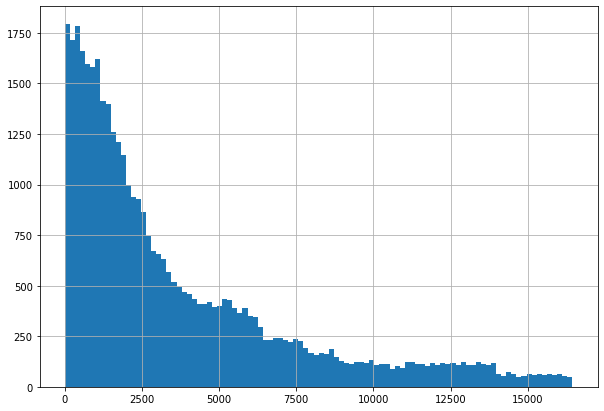

In [367]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

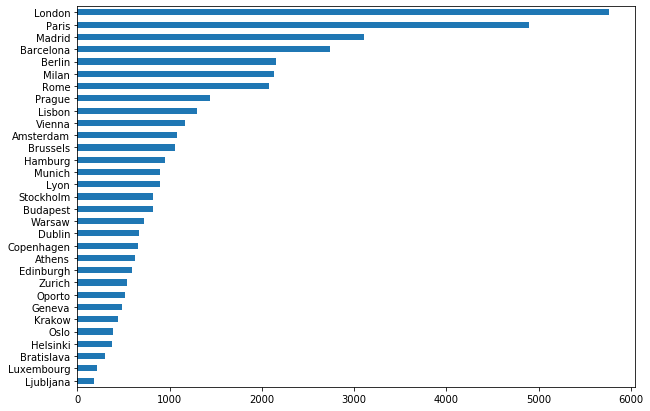

In [368]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

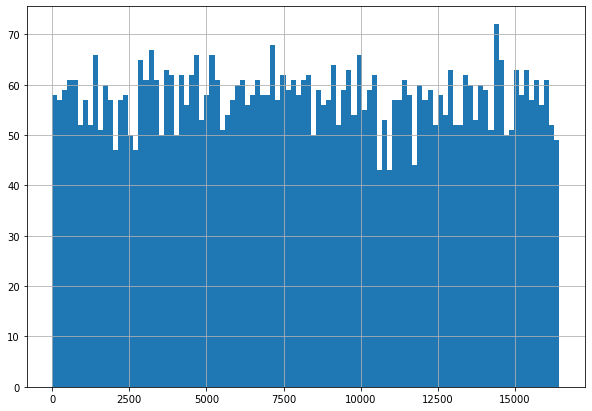

In [369]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

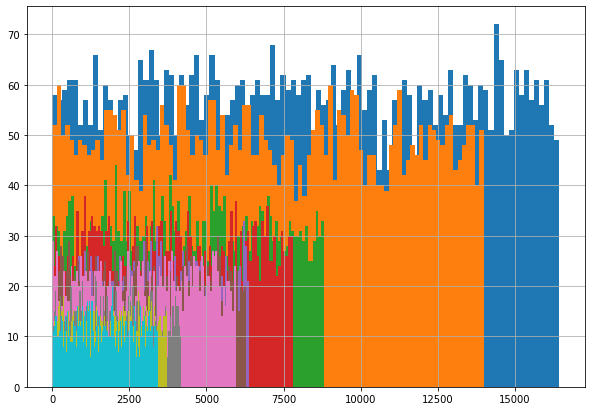

In [370]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

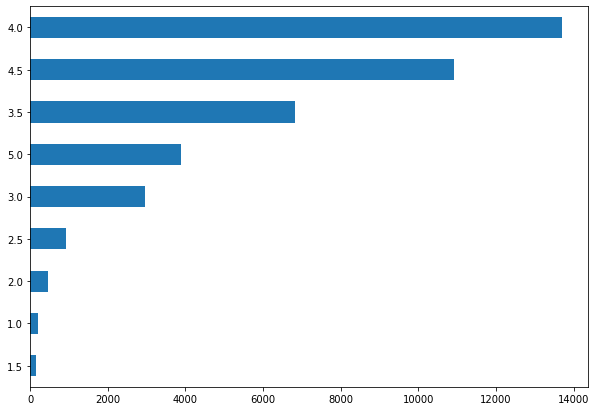

In [371]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

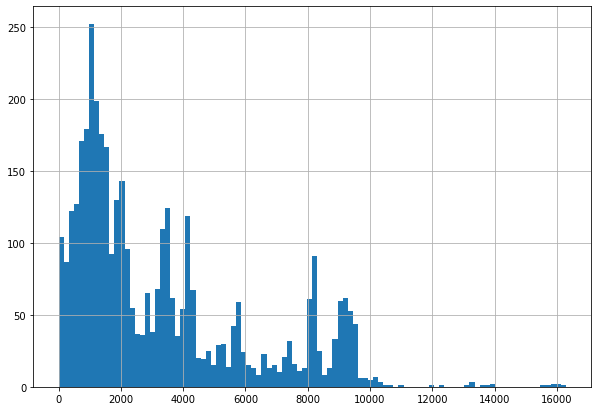

In [372]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

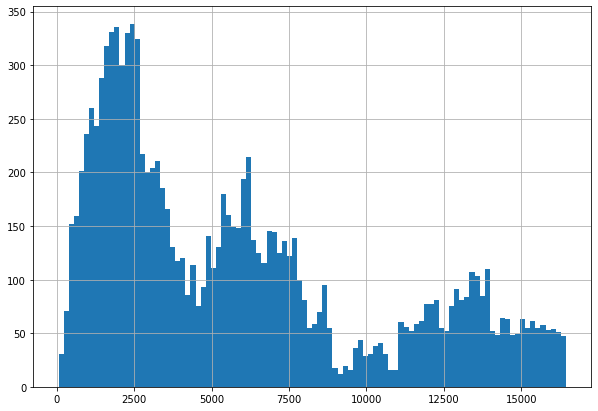

In [373]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

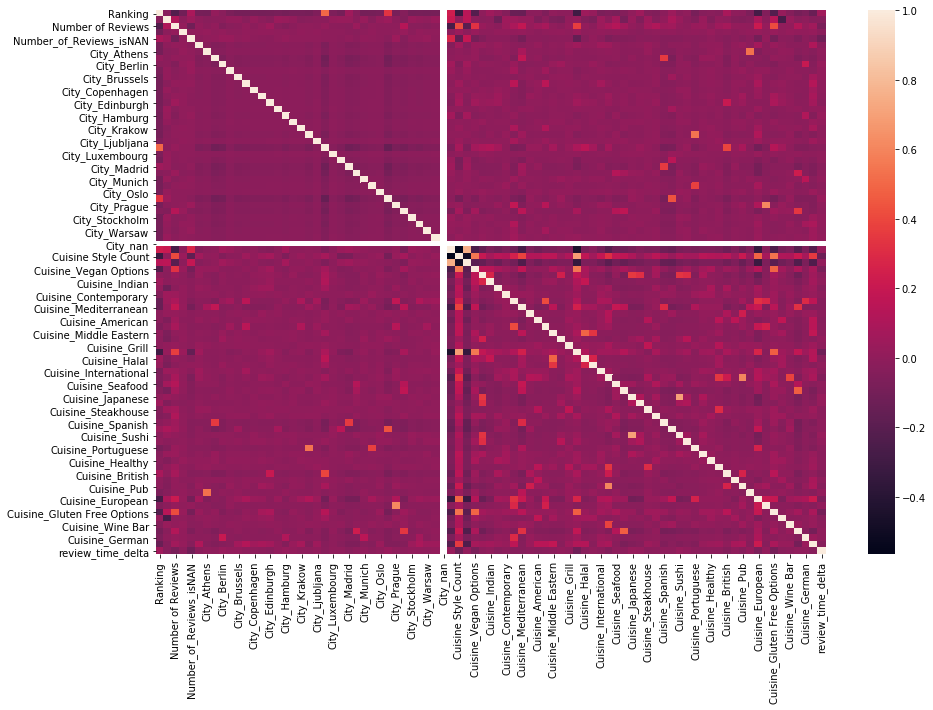

In [374]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [375]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [389]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number_of_Reviews_isNAN'] = pd.isna(df_output['Number of Reviews']).astype('uint8')
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    
    df_output['Price Range'].replace(to_replace={ '$': 1, '$$ - $$$': 2, '$$$$': 3}, inplace=True)
    df_output['Price Range'].value_counts()
    df_output['Price_Range_isNAN'] = pd.isna(df_output['Price Range']).astype('uint8')
    df_output['Price_Range_isNAN']
    df_output['Price Range'].fillna(df_output['Price Range'].median(), inplace=True)

    df_output['Cuisine Style Count'] = df_output['Cuisine Style'].apply(count_styles)

    for cuisine in top_cuisines:
        dummy = df_output['Cuisine Style'].apply(is_cuisine_present)

    df_output['Cuisine_' + cuisine] = dummy
    df_output['Cuisine_Other'] = df_output['Cuisine Style'].apply(is_low_cuisine_present)

    df_output['Reviews'].fillna('[[], []]', inplace=True)
    df_output['Penultimate_Review'] = df_output['Reviews'].apply(lambda x: get_penultimate_review(x))
    df_output['Last_Review'] = df_output['Reviews'].apply(lambda x: get_last_review(x))

    df_output = df_output.assign(review_time_delta = lambda x: (x['Last_Review'] - x['Penultimate_Review']).dt.days)
    df_output['review_time_delta'] = df_output['review_time_delta'].fillna(0)
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    # object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    # df_output.drop(object_columns, axis = 1, inplace=True)

    object_cols = list(df_output.select_dtypes(include=['object', 'datetime64[ns]', 'timedelta64[ns]']).columns)
    df_output = df_output.drop(labels=object_cols, axis=1)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [390]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

KeyError: 'review_time_delta'

In [386]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ranking                  50000 non-null  float64
 1   Price Range              50000 non-null  float64
 2   Number of Reviews        50000 non-null  float64
 3   sample                   50000 non-null  int64  
 4   Rating                   50000 non-null  float64
 5   Number_of_Reviews_isNAN  50000 non-null  uint8  
 6   City_Amsterdam           50000 non-null  uint8  
 7   City_Athens              50000 non-null  uint8  
 8   City_Barcelona           50000 non-null  uint8  
 9   City_Berlin              50000 non-null  uint8  
 10  City_Bratislava          50000 non-null  uint8  
 11  City_Brussels            50000 non-null  uint8  
 12  City_Budapest            50000 non-null  uint8  
 13  City_Copenhagen          50000 non-null  uint8  
 14  City_Dublin           

In [332]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [333]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [334]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 35), (40000, 35), (40000, 34), (32000, 34), (8000, 34))

# Model 
Сам ML

In [40]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [41]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [42]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [43]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21240125


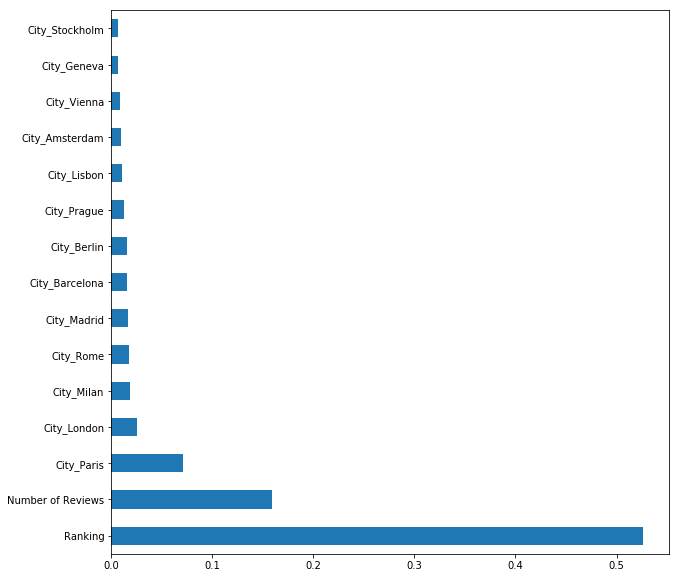

In [44]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [45]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
846,1582.0,41.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3516,1539.0,30.0,0.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1237,1681.0,11.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8016,4764.0,58.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7188,3239.0,3.0,0.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3901,2978.0,4.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8724,1086.0,169.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5766,951.0,48.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8878,3149.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7870,1138.0,11.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
test_data = test_data.drop(['Rating'], axis=1)

In [47]:
sample_submission

,Restaurant_id,Rating
0,id_0,0.5
1,id_1,1.0
2,id_2,1.5
3,id_3,2.0
4,id_4,2.5
...,...,...
9995,id_9995,3.0
9996,id_9996,3.5
9997,id_9997,4.0
9998,id_9998,4.5


In [48]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [49]:
predict_submission

array([3.005, 4.295, 4.56 , ..., 3.   , 4.5  , 4.32 ])

In [50]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.005
1,id_1,4.295
2,id_2,4.560
3,id_3,4.155
4,id_4,4.485
5,id_5,4.580
6,id_6,1.475
7,id_7,3.220
8,id_8,4.100
9,id_9,4.750


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
